# Case de Telemedicina e Data Science - Análise de Sobrevivencia
Este notebook tem o objetivo de predizer o tempo em que um usuario permanecerá com o contrato ativo na plataforma da cuidas. 

[Artigo de referencia 1](https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e) e [artigo de referencia 2](https://imasters.com.br/data/vamos-falar-sobre-analise-de-sobrevivencia-survival-analysis)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from lifelines.plotting import plot_lifetimes      # Lifeline package for the Survival Analysis
%pylab inline
figsize(12,6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%y')
appointments = pd.read_csv('dataset/appointments.csv'
                           ,parse_dates = ['appointment_date']
                           ,date_parser = dateparse)
nps = pd.read_csv('dataset/nps.csv')
users = pd.read_csv('dataset/users.csv'
                           ,parse_dates = ['birth_date', 'start_date', 'end_date']
                           ,date_parser = dateparse)

/Users/victordesanunes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


Uma observação é chamada de dado censurado quando a informação sobre seu tempo de sobrevivência está incompleta. Por exemplo: se o caso estudado é de churn, se um cliente não sair do serviço durante o estudo, então ele é considerado censored (censurado). Outra forma de uma observação ser “censored” é se o usuário observado sair do estudo antes que aconteça o evento esperado.

Observando as datas de encerramento do contrato podemos perceber que há dados até Setembro de 2014. Iremos definir que datas anteriores a 01-01-2014 não encerraram o contrato. 

In [3]:
appointments_user = appointments.merge(nps)[['appt_id', 'user_id', 'channel', 'type', 'nps']]

# Calcula estatisticas dos usuarios
length = lambda x: len(x.unique())
user_stats = appointments_user.groupby(by = ['user_id']).agg({'appt_id': 'count'
                                                                ,'type': 'unique'
                                                                ,'nps': 'mean'
                                                                ,'type': length
                                                                ,'channel': length})\
                                                        .rename({'appt_id': 'total_appt'
                                                                ,'type': 'total_type'
                                                                ,'channel': 'total_channel'}, axis = 1)
user_stats.reset_index(level=0, inplace=True)

In [4]:
import datetime as dt

users['event_observed'] = users['end_date'].apply(lambda x: 1 if x >= dt.date(2014,1,1) else 0 )

users.head()

,user_id,gender,birth_date,start_date,end_date,city_code,event_observed
0,1,female,1981-07-07,2010-06-29,2010-11-02,3,0
1,2,male,1996-10-08,2011-01-18,2012-02-18,1,0
2,3,female,1986-06-03,2010-01-13,2010-09-12,3,0
3,4,male,1992-07-28,2010-11-19,2012-08-01,3,0
4,5,male,1981-04-21,2011-08-27,2011-12-11,2,0


In [5]:
users = users.merge(user_stats)
users['active_time_days'] = (users['end_date'] - users['start_date'])
users['active_time_days'] = users['active_time_days'].dt.days
users['age_at_activation'] = users['start_date'] - users['birth_date']
users['age_at_activation'] = (users['age_at_activation'].dt.days)/365
users['age_at_activation'] = users['age_at_activation'].apply(lambda x: int(x))
users.head()

,user_id,gender,birth_date,start_date,end_date,city_code,event_observed,total_appt,total_type,nps,total_channel,active_time_days,age_at_activation
0,1,female,1981-07-07,2010-06-29,2010-11-02,3,0,2,2,9,1,126,28
1,2,male,1996-10-08,2011-01-18,2012-02-18,1,0,7,2,5,2,396,14
2,3,female,1986-06-03,2010-01-13,2010-09-12,3,0,4,2,5,1,242,23
3,4,male,1992-07-28,2010-11-19,2012-08-01,3,0,8,2,10,2,621,18
4,5,male,1981-04-21,2011-08-27,2011-12-11,2,0,1,1,8,1,106,30


Para essa analise iremos criar dois cohorts baseado no genero do usuario

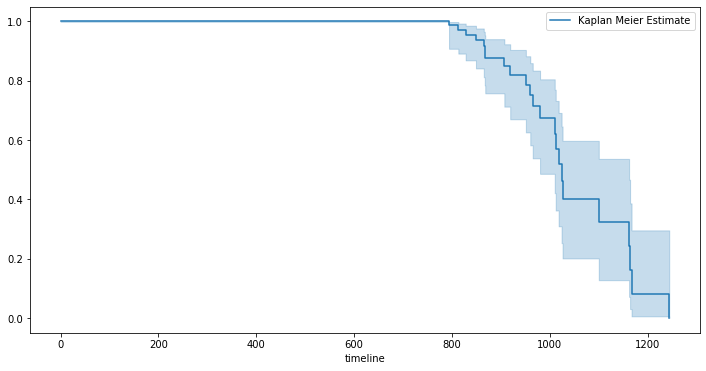

In [6]:
from lifelines import KaplanMeierFitter

durations = users['active_time_days'] ## Time to event data of censored and event data
event_observed = users['event_observed']  ## It has the churned (1) and censored is (0)

## create a kmf object as km
km = KaplanMeierFitter() ## instantiate the class to create an object

## Fit the data into the model
km.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
km.plot()

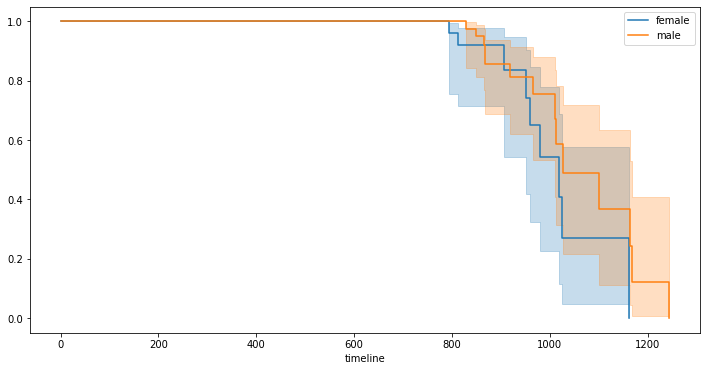

In [7]:
kmf = KaplanMeierFitter() 


T = users['active_time_days']    ## time to event
E = users['event_observed']      ## event occurred or censored


groups = users['gender']             ## Create the cohorts from the 'Contract' column
ix1 = (groups == 'female')   ## Cohort 1
ix2 = (groups == 'male')         ## Cohort 2


kmf.fit(T[ix1], E[ix1], label='female')    ## fit the cohort 1 data
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='male')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax)

## Analisando churn de usuarios de acordo com a quantidade de canais de atendimento

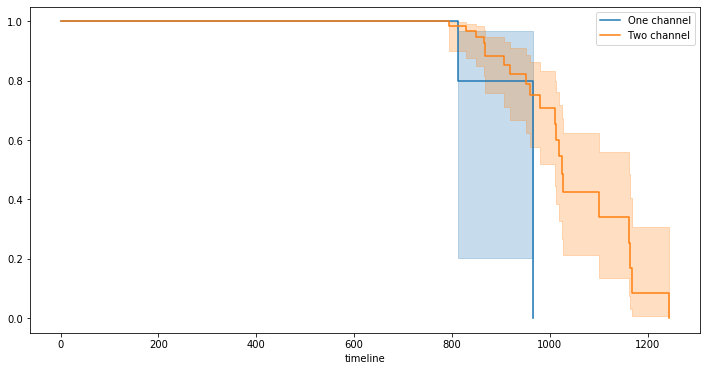

In [8]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. 1. Streaming TV Not Subsribed by Users, 2. Streaming TV subscribed by the users.
groups = users['total_channel']   
i1 = (groups == 1)      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 2)     ## group i2 , having the pandas series for the 2nd cohort


## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='One channel')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Two channel')
kmf1.plot(ax=a1)

## Analisando churn de usuarios por cidade

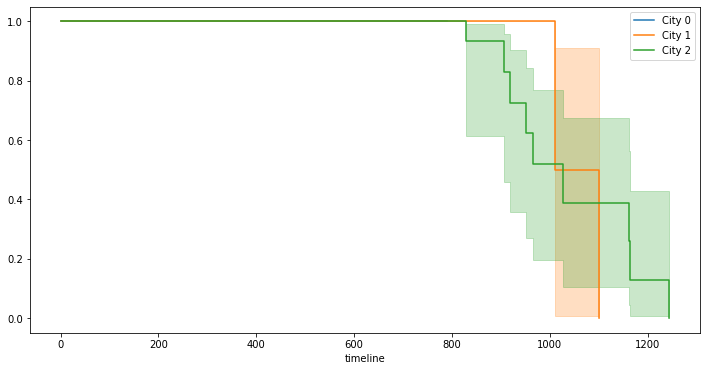

In [9]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. 1. Streaming TV Not Subsribed by Users, 2. Streaming TV subscribed by the users.
groups = users['city_code']   
i0 = (groups == 0)
i1 = (groups == 1)
i2 = (groups == 2)
i3 = (groups == 3)
i4 = (groups == 4)
i5 = (groups == 5)
i6 = (groups == 6)

kmf1.fit(T[i0], E[i0], label='City 0')
a0 = kmf1.plot()

kmf1.fit(T[i1], E[i1], label='City 1')
a1 = kmf1.plot()

kmf1.fit(T[i2], E[i2], label='City 2')
a2 = kmf1.plot()

# kmf1.fit(T[i3], E[i3], label='City 3')
# a3 = kmf1.plot()

# kmf1.fit(T[i4], E[i4], label='City 4')
# a4 = kmf1.plot()

# kmf1.fit(T[i5], E[i5], label='City 5')
# a5 = kmf1.plot()

# kmf1.fit(T[i6], E[i6], label='City 6')
# ax6 = kmf1.plot(ax=a1)

## Analisando churn de usuarios de acordo com a quantidade de canais de atendimento

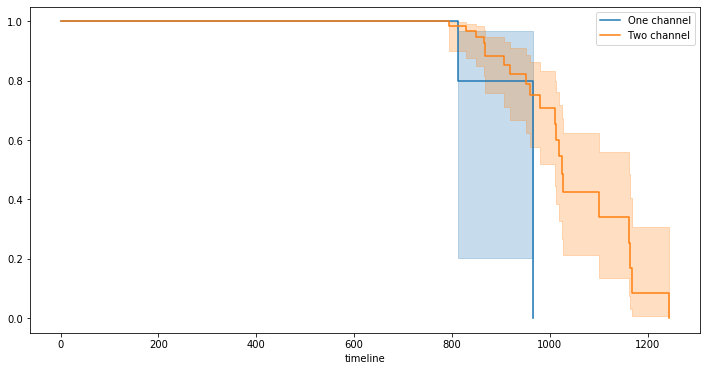

In [10]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. 1. Streaming TV Not Subsribed by Users, 2. Streaming TV subscribed by the users.
groups = users['total_channel']   
i1 = (groups == 1)      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 2)     ## group i2 , having the pandas series for the 2nd cohort


## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='One channel')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Two channel')
kmf1.plot(ax=a1)

In [11]:
df_dummy = pd.get_dummies(users, drop_first = True, 
                          columns = ['city_code', 'gender']).drop(columns = ['user_id', 'start_date', 'end_date', 'birth_date'])
df_dummy.head()

,event_observed,total_appt,total_type,nps,total_channel,active_time_days,age_at_activation,city_code_1,city_code_2,city_code_3,city_code_4,city_code_5,city_code_6,gender_male
0,0,2,2,9,1,126,28,0,0,1,0,0,0,0
1,0,7,2,5,2,396,14,1,0,0,0,0,0,1
2,0,4,2,5,1,242,23,0,0,1,0,0,0,0
3,0,8,2,10,2,621,18,0,0,1,0,0,0,1
4,0,1,1,8,1,106,30,0,1,0,0,0,0,1


In [12]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)   ## Instantiate the class to create a cph object
cph.fit(df_dummy, 'active_time_days', event_col='event_observed')   ## Fit the data to train the model
cph.print_summary()  

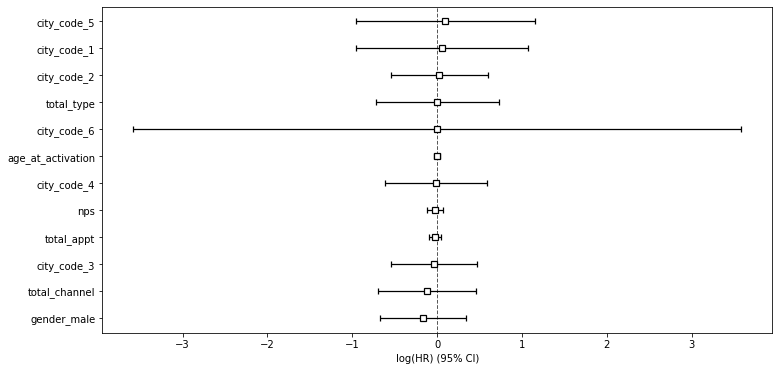

In [13]:
cph.plot()

In [14]:
tr_rows = df_dummy.iloc[7:10].drop(columns = ['event_observed', 'active_time_days'])
tr_rows

,total_appt,total_type,nps,total_channel,age_at_activation,city_code_1,city_code_2,city_code_3,city_code_4,city_code_5,city_code_6,gender_male
7,9,2,9,2,17,0,1,0,0,0,0,0
8,1,1,7,1,25,0,1,0,0,0,0,1
9,9,2,3,2,23,0,0,1,0,0,0,1


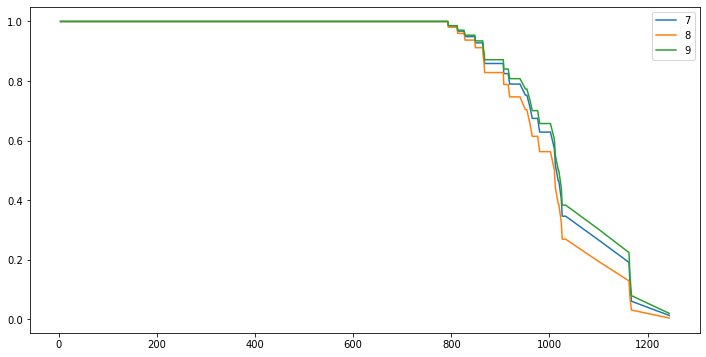

In [15]:
cph.predict_survival_function(tr_rows).plot()

In [16]:
df_dummy.iloc[7:10][['event_observed', 'active_time_days']]

,event_observed,active_time_days
7,1,907
8,0,143
9,0,618
